In [12]:
import backtrader as bt
import os
import sys
import datetime

In [13]:
from backtrader.indicators import EMA

启动资金: 2000000.00
2020-04-01, 买入, 7276.90
2020-06-17, 卖出, 9243.21
2020-06-18, 交易中，毛利201764.29, 净利 193516.83
2020-06-23, 买入, 9734.78
2020-07-24, 卖出, 11096.38
2020-07-27, 交易中，毛利146715.65, 净利 136300.56
2020-08-25, 买入, 12620.64
2020-09-09, 卖出, 12199.43
2020-09-10, 交易中，毛利-23746.80, 净利 -36241.45
2020-10-14, 买入, 13153.49
2020-11-26, 卖出, 14950.27
2020-11-27, 交易中，毛利178486.34, 净利 164448.67
2020-12-10, 买入, 15749.86
2021-01-15, 卖出, 18277.11
2021-01-18, 交易中，毛利233705.73, 净利 216777.00
2021-02-09, 买入, 19991.52
2021-02-22, 卖出, 18470.80
2021-02-23, 交易中，毛利-208347.83, 净利 -227476.65
2021-03-26, 买入, 16078.08
2021-06-11, 卖出, 19620.71
2021-06-15, 交易中，毛利333486.38, 净利 315579.07
2021-09-01, 买入, 15422.97
2021-10-29, 卖出, 16981.25
2021-11-01, 交易中，毛利115109.66, 净利 99102.80
2021-11-22, 买入, 17309.56
2021-12-22, 卖出, 18219.12
2021-12-23, 交易中，毛利105955.25, 净利 88193.04
2022-02-16, 买入, 16614.15
2022-03-04, 卖出, 15474.67
2022-03-07, 交易中，毛利-131647.12, 净利 -147644.13
2022-04-12, 买入, 14052.18
2022-07-11, 卖出, 16289.40
2022-07-12, 交易

<IPython.core.display.Javascript object>


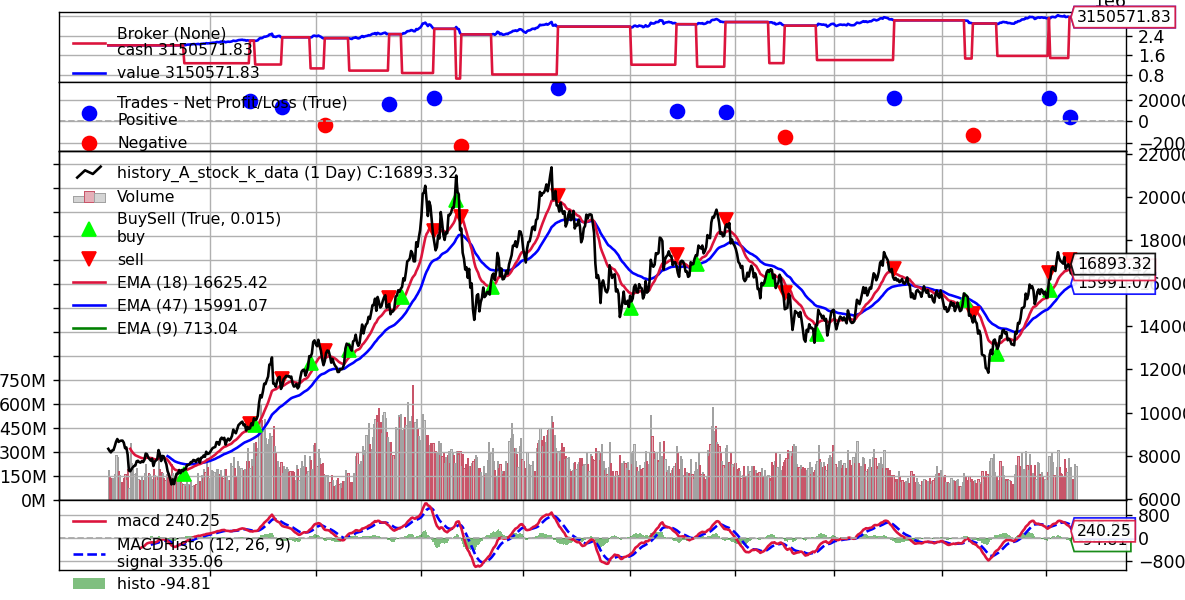

In [15]:

class TestStrategy(bt.Strategy):
    """
    构建自己的策略
    """

    def log(self, txt, dt=None, doprint=False):
        ''' 日志函数，用于统一输出日志格式 '''
        if doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):

        # 初始化相关数据
        self.dataclose = self.datas[0].close
        # 成交量
        self.volume = self.datas[0].volume
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # 计算两个EMA均线和MACD信号
        ema1 = EMA(self.data, period=18)
        ema2 = EMA(self.data, period=47)
        self.macd = ema1 - ema2
        self.signal = EMA(self.macd, period=9)
        #画图
        bt.indicators.MACDHisto(self.data)

    def notify_order(self, order):
        """
        订单状态处理
        Arguments:
            order {object} -- 订单状态
        """
        if order.status in [order.Submitted, order.Accepted]:
            # 如订单已被处理，则不用做任何事情
            return

        # 检查订单是否完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            self.bar_executed = len(self)

        # 订单因为缺少资金之类的原因被拒绝执行
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消或被拒绝',doprint=True)

        # 订单状态处理完成，设为空
        self.order = None

    def notify_trade(self, trade):
        """
        交易成果
        
        Arguments:
            trade {object} -- 交易状态
        """
        if not trade.isclosed:
            return

        # 显示交易的毛利率和净利润
        self.log('交易中，毛利%.2f, 净利 %.2f' %
                 (trade.pnl, trade.pnlcomm), doprint=True)

    def next(self):
        ''' 下一次执行 '''

        # 记录收盘价
        self.log('Close, %.2f' % self.dataclose[0])

        # 是否正在下单，如果是的话不能提交第二次订单
        if self.order:
            return

        # 是否已经买入
        if not self.position:
            #第一个条件，前一天di
            condition1 = self.macd[-1] - self.signal[-1]
            condition2 = self.macd[0] - self.signal[0]
            if condition1 < 0 and condition2 > 0:
                self.log('买入, %.2f' % self.dataclose[0],doprint=True)
                self.order = self.buy()
        else:
            condition1 = self.macd[-1] - self.signal[-1]
            condition2 = self.macd[0] - self.signal[0]
            if condition1 > 0 and condition2 < 0:
                self.log('卖出, %.2f' % self.dataclose[0],doprint=True)
                self.order = self.sell()

    def stop(self):
        self.log(u'最终的账户资产为%.2f' %
                 (self.broker.getvalue()), doprint=True)


if __name__ == '__main__':

    # 初始化模型
    cerebro = bt.Cerebro()

    # 构建策略
    strats = cerebro.addstrategy(TestStrategy)
    # 每次买100股
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # 加载数据到模型中
    data = bt.feeds.GenericCSVData(
        dataname='../第一课/history_A_stock_k_data.csv',
        fromdate=datetime.datetime(2020, 1, 1),
        todate=datetime.datetime(2023, 2, 12),
        dtformat='%Y-%m-%d',
        datetime=0,
        open=2,
        high=3,
        low=4,
        close=5,
        volume=7
    )
    cerebro.adddata(data)

    # 设定初始资金和佣金
    cerebro.broker.setcash(2000000.0)
    cerebro.broker.setcommission(0.005)

    # 策略执行前的资金
    print('启动资金: %.2f' % cerebro.broker.getvalue())

    # 策略执行
    cerebro.run()
    # 画图
    cerebro.plot()